# Desarrollo M2

In [145]:
%load_ext autoreload
%autoreload 2

import os
import sys
project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import seaborn
# seaborn.set_context(context="talk")

from torch.utils.data import DataLoader

from src.data.dataset import lc_dataset
from src.models.model import periodicTransformer
from src.visualization.plots import plot_periodic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objetivos

1) Cambiar el codificador posicional actual (discreto) a uno continuo, puede ser el de T. Sousa o O. Pimentel
2) Probar con un conjunto más amplio de clases (curvas sinteticas), por lo que vi tienen dos clases por ahora, traten de extender el problema a almenos 4
3) realizar pruebas con curvas dobladas (en fase), curvas no dobladas y otras con fase aumentada (esto es simplemente entregar dos fases o tres, una tras la otra)
4) Observar como se comportan los pesos de atención en el caso de series periodicas vs no periodicas, para esto recomiendo que dentro de las 4 clases periodicas que vayan a generar integren una quinta que sea no periodica, sería interesante ver como clasifica esta serie no periodica si el modelo fue entrenado con solo curvas periodicas
5) Esto es un poco más libre, pero generar algunas figuras como matrices de confusión, curvas roc, curvas de perdida o accuracy en el tiempo, visualización de el espacio de caracteristicas etc..

## Clasificación de 5 clases

### Generaciónd de datos

In [124]:
train_data = lc_dataset()
train_data.add_curves('sinmix', N=800, seq_len=200, min_period=0.5, max_period=2, label=0)
train_data.add_curves('sinmix', N=800, seq_len=200, min_period=5, max_period=10, label=1)
train_data.add_curves('sawtooth', N=800, seq_len=200, min_period=1.5, max_period=4, label=2)
train_data.add_curves('square', N=800, seq_len=200, min_period=2, max_period=8, label=3)
train_data.add_curves('gauss', N=800, seq_len=200, min_period=2, max_period=8, label=4)

val_data = lc_dataset(seed=127)
val_data.add_curves('sinmix', N=300, seq_len=200, min_period=0.5, max_period=2, label=0)
val_data.add_curves('sinmix', N=300, seq_len=200, min_period=5, max_period=10, label=1)
val_data.add_curves('sawtooth', N=300, seq_len=200, min_period=1.5, max_period=4, label=2)
val_data.add_curves('square', N=300, seq_len=200, min_period=2, max_period=8, label=3)
val_data.add_curves('gauss', N=300, seq_len=200, min_period=2, max_period=8, label=4)

### Visualización del dataset

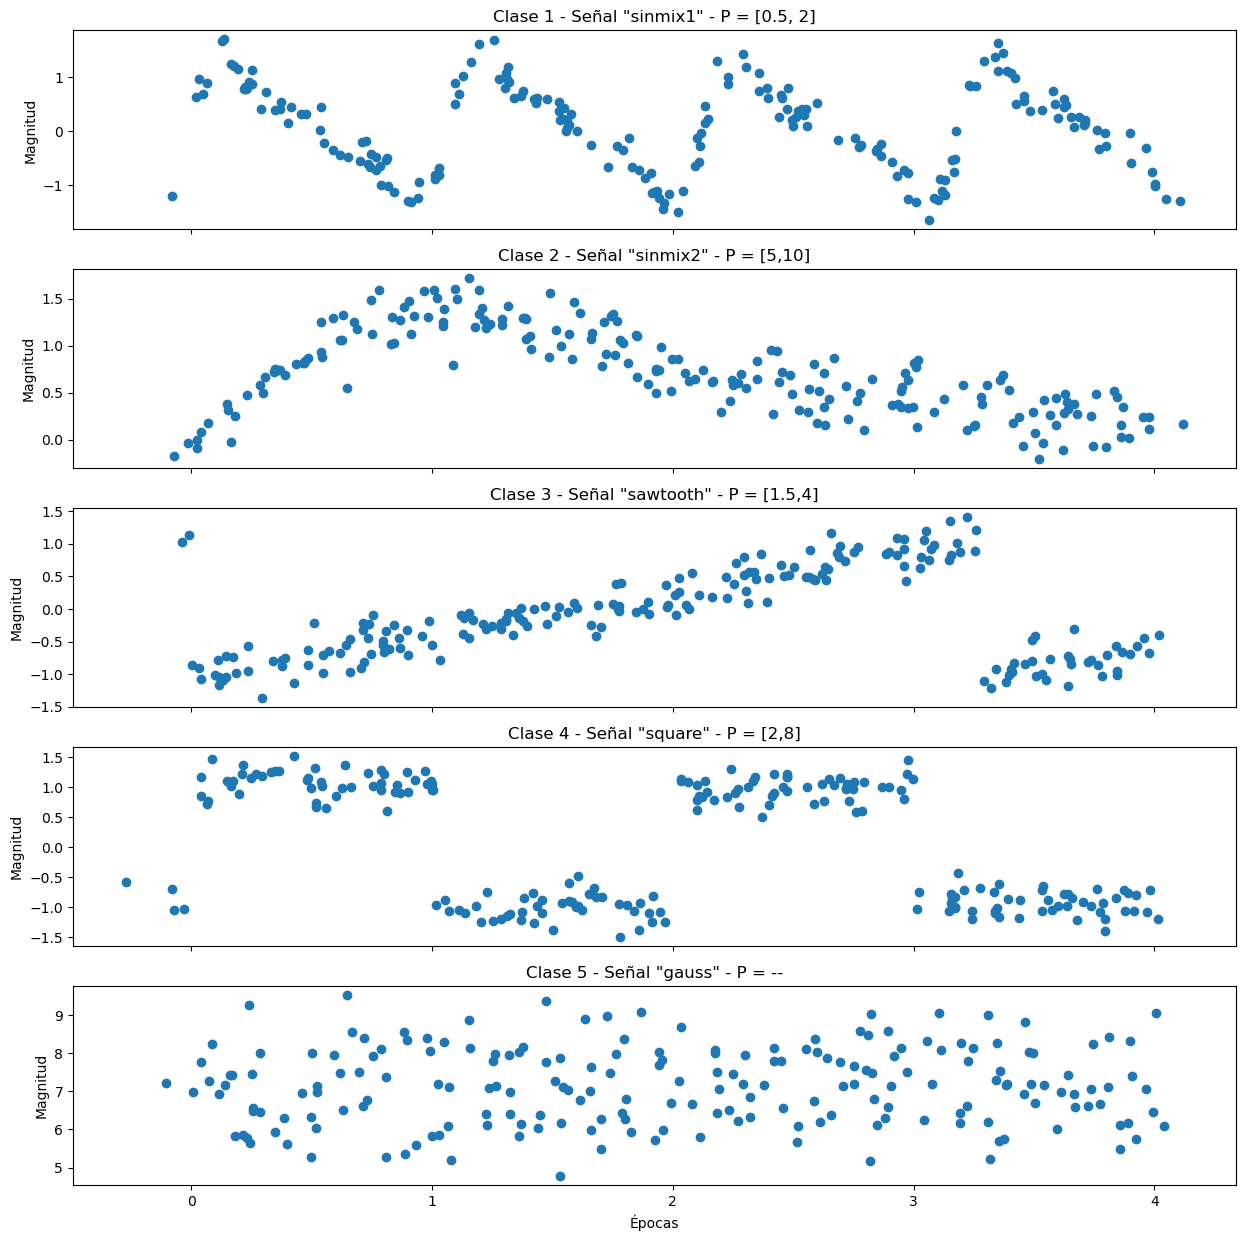

In [125]:
fig, ax = plt.subplots(5, figsize=(15,15), sharex=True)

for label in range(5):
    temp_data = train_data.to_df().loc[train_data.to_df()['label'] == label].iloc[0].copy()
    ax[label].scatter(temp_data.mjd, temp_data.mag)
    ax[label].set_ylabel('Magnitud')
ax[0].set_title('Clase 1 - Señal "sinmix1" - P = [0.5, 2]')
ax[1].set_title('Clase 2 - Señal "sinmix2" - P = [5,10]')
ax[2].set_title('Clase 3 - Señal "sawtooth" - P = [1.5,4]')
ax[3].set_title('Clase 4 - Señal "square" - P = [2,8]')
ax[4].set_title('Clase 5 - Señal "gauss" - P = --')
plt.xlabel('Épocas')
plt.show()

### Clasificación

#### DataLoaders

In [126]:
batch_size = 64


train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            pin_memory=True,
                            num_workers=16,
                            shuffle=True)

val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16,
                        shuffle=True)                


#### Generación del modelo

In [156]:
n_classes = 5
n_blocks = 6

tmp_model = periodicTransformer(n_classes=n_classes, N=n_blocks, d_model=200, d_ff=2048, h=8, dropout=0.1)

/home/agonzalez/projects/el7006/Projecto-EL7006/src/models/model.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


#### Training

In [168]:
loss, val_loss = tmp_model.fit(train_loader, val_loader, 10)

Epoch: 0 - Train loss: 1.3671766510015004e-06 - Val loss: 5.073047213954851e-05 - Val acc: 1.0
Epoch: 1 - Train loss: 3.0620994948549196e-06 - Val loss: 7.109973694241489e-07 - Val acc: 1.0
Epoch: 2 - Train loss: 3.553875103534665e-06 - Val loss: 8.680828614160419e-05 - Val acc: 1.0
Epoch: 3 - Train loss: 4.610594260157086e-05 - Val loss: 0.00018958405416924506 - Val acc: 1.0
Epoch: 4 - Train loss: 1.795575826690765e-06 - Val loss: 1.3095338545099366e-05 - Val acc: 1.0
Epoch: 5 - Train loss: 0.024178674444556236 - Val loss: 0.0007387204677797854 - Val acc: 1.0
Epoch: 6 - Train loss: 0.0002297439204994589 - Val loss: 1.743779102980625e-05 - Val acc: 1.0
Epoch: 7 - Train loss: 2.8979848138988018e-05 - Val loss: 1.6008058310035267e-06 - Val acc: 1.0
Epoch: 8 - Train loss: 8.087019523372874e-06 - Val loss: 1.6816927654872416e-06 - Val acc: 1.0
Epoch: 9 - Train loss: 2.0725805370602757e-05 - Val loss: 9.110969472203578e-07 - Val acc: 1.0


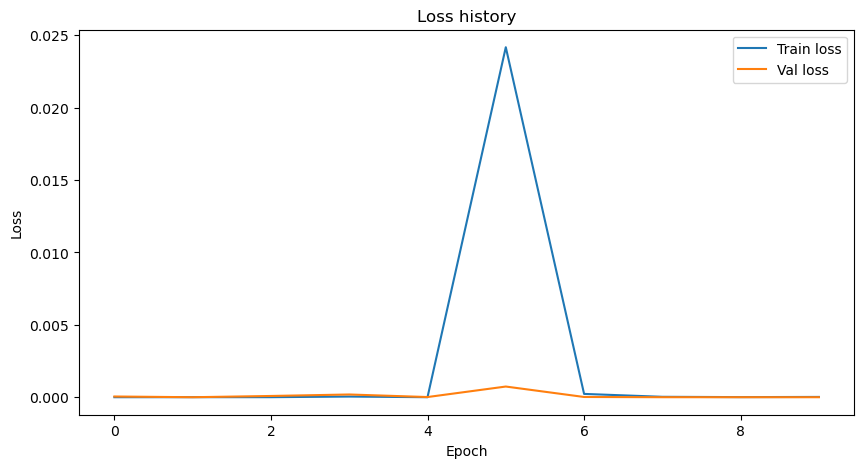

In [174]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(loss)
ax.plot(val_loss)
ax.set_title('Loss history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train loss', 'Val loss'])
plt.show()

#### Testing

In [146]:
test_data = lc_dataset(seed=10)
test_data.add_curves('sinmix', N=200, seq_len=200, min_period=0.5, max_period=2, label=0)
test_data.add_curves('sinmix', N=200, seq_len=200, min_period=5, max_period=10, label=1)
test_data.add_curves('sawtooth', N=200, seq_len=200, min_period=1.5, max_period=4, label=2)
test_data.add_curves('square', N=200, seq_len=200, min_period=2, max_period=8, label=3)
test_data.add_curves('gauss', N=200, seq_len=200, min_period=2, max_period=8, label=4)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16,
                        shuffle=True)    

_, test_predictions = tmp_model.test(test_loader)
test_predictions = np.array(test_predictions)

Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test batch acc: 1.0
Test avg acc: 1.0


#### Matriz de confusión

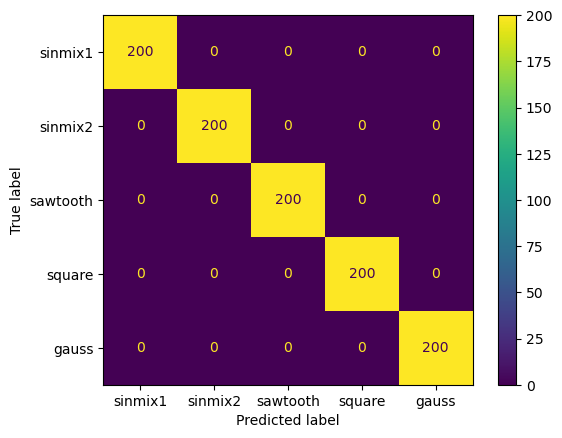

In [155]:
cm = confusion_matrix(
                    test_predictions[:,0],
                    test_predictions[:,1])
disp = ConfusionMatrixDisplay(
                            confusion_matrix=cm,
                            display_labels=[
                                'sinmix1',
                                'sinmix2',
                                'sawtooth',
                                'square',
                                'gauss'])
disp.plot()
plt.show()

## Propuesta a futuro

- Datos con tiempos en distintos intervalos
- Datos con distintos rangos de magnitudes
- Analizar como afecta desbalance